In [ ]:
!pip install torch torchvision matplotlib pillow


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from PIL import Image
import os


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 dataset automatically
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use a small subset for faster training
dataset = Subset(dataset, range(500))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


In [ ]:
def train_and_evaluate(model, name, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_accs.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accs.append(100 * correct / total)

        print(f"{name} Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accs[-1]:.2f}%, Val Acc: {val_accs[-1]:.2f}%")

    return model, train_accs, val_accs


In [ ]:
def get_model(name):
    if name == "vgg":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 10)
    elif name == "resnet":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif name == "googlenet":
        model = models.googlenet(pretrained=True, aux_logits=True)
        model.fc = nn.Linear(model.fc.in_features, 10)
    else:
        raise ValueError("Unknown model")
    return model


In [ ]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights, ResNet18_Weights, GoogLeNet_Weights

def get_model(name):
    if name == "vgg":
        model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(4096, 10)

    elif name == "resnet":
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 10)

    elif name == "googlenet":
        model = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)
        model.fc = nn.Linear(model.fc.in_features, 10)
        model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, 10)
        model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, 10)

    else:
        raise ValueError("Unknown model")

    return model


In [ ]:
# Dictionary to store results
results = {}

for model_name in ["vgg", "resnet", "googlenet"]:
    print(f"\n🔹 Training {model_name.upper()} on CIFAR-10...")
    model = get_model(model_name)
    trained_model, train_acc, val_acc = train_and_evaluate(model, model_name.upper(), num_epochs=5)

    # Save results
    results[model_name] = {
        "train_acc": train_acc,
        "val_acc": val_acc
    }



🔹 Training VGG on CIFAR-10...
VGG Epoch 1/5 - Train Acc: 9.75%, Val Acc: 5.00%
VGG Epoch 2/5 - Train Acc: 10.50%, Val Acc: 10.00%
VGG Epoch 3/5 - Train Acc: 13.25%, Val Acc: 11.00%
VGG Epoch 4/5 - Train Acc: 9.50%, Val Acc: 10.00%
VGG Epoch 5/5 - Train Acc: 11.50%, Val Acc: 6.00%

🔹 Training RESNET on CIFAR-10...
RESNET Epoch 1/5 - Train Acc: 41.00%, Val Acc: 34.00%
RESNET Epoch 2/5 - Train Acc: 78.00%, Val Acc: 30.00%
RESNET Epoch 3/5 - Train Acc: 91.50%, Val Acc: 56.00%
RESNET Epoch 4/5 - Train Acc: 91.50%, Val Acc: 49.00%
RESNET Epoch 5/5 - Train Acc: 99.25%, Val Acc: 51.00%

🔹 Training GOOGLENET on CIFAR-10...
GOOGLENET Epoch 1/5 - Train Acc: 39.25%, Val Acc: 48.00%
GOOGLENET Epoch 2/5 - Train Acc: 80.25%, Val Acc: 68.00%
GOOGLENET Epoch 3/5 - Train Acc: 92.00%, Val Acc: 65.00%
GOOGLENET Epoch 4/5 - Train Acc: 97.25%, Val Acc: 67.00%
GOOGLENET Epoch 5/5 - Train Acc: 98.50%, Val Acc: 64.00%


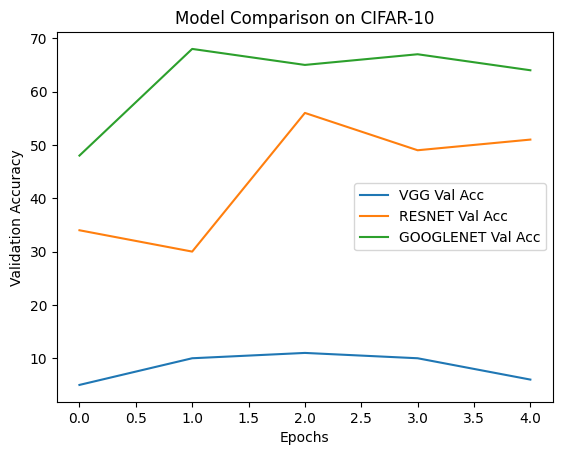

In [ ]:
import matplotlib.pyplot as plt

for model_name in results.keys():
    plt.plot(results[model_name]["val_acc"], label=f"{model_name.upper()} Val Acc")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison on CIFAR-10")
plt.legend()
plt.show()


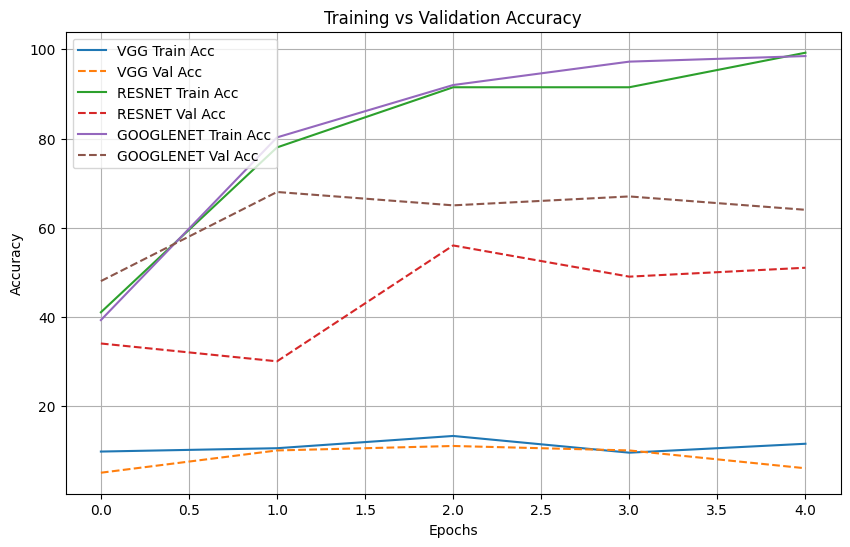

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(results):
    plt.figure(figsize=(10,6))
    for model_name in results.keys():
        plt.plot(results[model_name]["train_acc"], label=f"{model_name.upper()} Train Acc")
        plt.plot(results[model_name]["val_acc"], linestyle='--', label=f"{model_name.upper()} Val Acc")

    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(results)


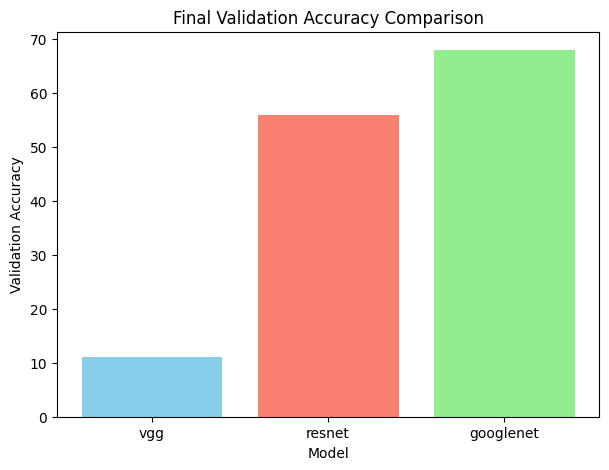

In [ ]:
final_val_acc = [max(results[m]["val_acc"]) for m in results.keys()]

plt.figure(figsize=(7,5))
plt.bar(results.keys(), final_val_acc, color=['skyblue','salmon','lightgreen'])
plt.title("Final Validation Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.show()
